In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Set-up Starting Dist

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.31999311, 0.33252229, 0.3474846 ],
        [0.64619769, 0.12175654, 0.23204577],
        [0.36064754, 0.33243814, 0.30691432]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 2)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'R', 14, 3)

In [4]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [5]:
unbiased_model = maxentep.ParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_model(tf.constant([1.]))

[<tfp.distributions.Independent 'unbiased_model_R_dist_dist_Independentunbiased_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_T_dist_dist_Independentunbiased_model_T_dist_dist_unbiased_model_T_dist_dist_reciprocalunbiased_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'unbiased_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_beta_dist_Independentunbiased_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

## Create Trainable Joint

In [6]:
model = maxentep.ParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [7]:
model.compile(tf.optimizers.Adam(1e-1))
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 3, 3)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________

## Test out the prior distributions

In [8]:
p = model(tf.constant([1.]))
p

[<tfp.distributions.Independent 'param_model_model_R_dist_dist_Independentparam_model_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'param_model_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_beta_dist_Independentparam_model_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

In [9]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [10]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.9294777, 6.298708 ], dtype=float32)>

In [11]:
s = [x.sample(2) for x in p]
print(s)

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0.408706  , 0.32112965, 0.0400539 ],
        [0.64914834, 0.98108125, 0.15660952],
        [0.3633466 , 0.6101848 , 1.6774404 ]],

       [[0.9094801 , 1.6227934 , 1.1486933 ],
        [1.0852706 , 0.22143611, 0.25368878],
        [0.6587392 , 0.10231547, 0.40707633]]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.30926493, 0.29871932, 0.05592052],
       [0.47164595, 0.43655297, 0.07208955]], dtype=float32)>, <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.        , 0.        , 1.        , 0.45979968, 0.2864961 ,
        0.42573938],
       [1.        , 0.        , 0.        , 0.22362255, 0.1923849 ,
        0.44051424]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.1788871],
       [0.2199021]], dtype=float32)>]


In [12]:
p[1].log_prob(s[1])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.74078 , 2.628776], dtype=float32)>

In [13]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [14]:
[pi.log_prob(si) for pi, si in zip(p, s)]

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-4.5396895, -4.881006 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.74078 , 2.628776], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.5224227 , -0.28643245], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.2452416, 0.8375747], dtype=float32)>]

In [15]:
model.evaluate(tf.constant([1., 1.]), s)

1/1 [==============================] - 0s 2ms/step - loss: -0.6528 - R-dist-dist_loss: 4.7103 - T-dist-dist_loss: -3.6848 - rho-dist-dist_loss: 0.4044 - beta-dist_loss: -2.0828


[-0.6528191566467285,
 4.710347652435303,
 -3.6847779750823975,
 0.40442758798599243,
 -2.0828163623809814]

## Sampling Functions

In [16]:
v = model.sample(2)
v

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[1.5479224 , 0.14063428, 0.6879176 ],
         [1.276516  , 0.00924568, 1.4367051 ],
         [0.82764333, 0.8912165 , 0.17378138]],
 
        [[0.2669337 , 0.64107436, 0.49605376],
         [0.14843199, 0.04912343, 0.61136794],
         [0.8575545 , 0.3927583 , 0.5390202 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
 array([[[0.82572085, 0.17427915, 0.        , 0.        ],
         [0.        , 0.5884989 , 0.4115011 , 0.        ],
         [0.        , 0.        , 0.92389923, 0.07610077],
         [0.        , 0.        , 0.        , 1.        ]],
 
        [[0.84452635, 0.15547365, 0.        , 0.        ],
         [0.        , 0.6856949 , 0.31430513, 0.        ],
         [0.        , 0.        , 0.9296661 , 0.07033388],
         [0.        , 0.        , 0.        , 1.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
 array([[[0.       , 0.       , 0.       , 0. 

## Make some restraints

In [17]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [18]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [19]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

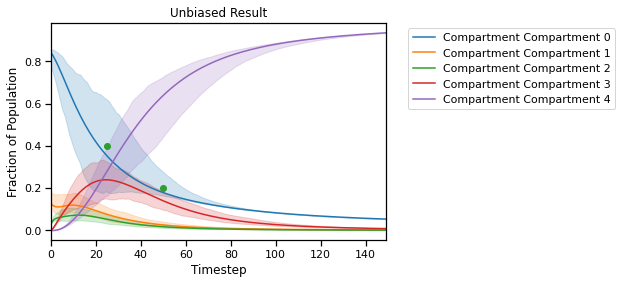

In [20]:
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [ ]:
me_loss = []
# sample and get batch
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

In [ ]:
plt.plot(me_loss)
plt.show()

In [ ]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [ ]:
maxent_hyper_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_hyper_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
maxent_hyper_model.fit(param_batch_size, 16, batch_size=32, epochs=8)

## Compare Weights

In [ ]:
sns.distplot(x=maxent_hyper_model.traj_weights)
plt.xlim(0,0.01)
plt.show()
sns.distplot(x=maxent_model.traj_weights)
plt.xlim(0,0.01)
plt.show()

In [ ]:
w = maxent_hyper_model.traj_weights
trajs = maxent_hyper_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Compare Hyper-parameter values

In [ ]:
ub = unbiased_model.get_layer('T-dist-hypers').w.numpy().flatten()
b = model.get_layer('T-dist-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

In [ ]:
ub = unbiased_model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
b = model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

In [ ]:
ub = unbiased_model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
b = model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

## Now compare with Directed regression

In [ ]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [ ]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

In [ ]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()